### Data Loading

이 데이터셋에는 2010년 1월부터 2020년 1월까지의 약 10년간의 환율 가격이 저장되어 있는 데이터셋이다. 최근 데이터(몇 일치 데이터 포인트)를 입력을 사용하여 모델을 만들고 1일 뒤의 달러 가격을 예측하는 모델을 만든다.

In [1]:
import pandas as pd
data = pd.read_csv('../data/DAILY_DATA.csv')

### Set Index

데이터셋의 Index는 날짜를 사용한다.

In [2]:
data = data.set_index('date')

### Feature Selecting : CAD, CHF, EUR, GBP, JPY(100), USD

사용할 데이터 : 캐나다 달러, 스위스 프랑, 유로, 영국 파운드, 일본 옌화, 미국 달러

In [3]:
data = data.dropna(axis=1)

In [4]:
data

,CAD,CHF,EUR,GBP,JPY(100),USD
date,,,,,,
2010-01-04,1110.15,1128.17,1673.46,1883.46,1256.50,1161.0
2010-01-05,1109.76,1122.31,1665.97,1860.44,1250.96,1147.3
2010-01-06,1101.19,1106.67,1643.96,1829.39,1248.35,1141.4
2010-01-07,1102.69,1107.41,1639.52,1822.54,1232.35,1132.0
2010-01-08,1095.51,1095.46,1621.38,1804.73,1211.91,1134.1
...,...,...,...,...,...,...
2020-01-23,886.78,1203.86,1292.74,1530.94,1060.87,1165.1
2020-01-28,884.81,1203.42,1286.20,1524.01,1071.37,1167.2
2020-01-29,893.84,1209.35,1296.84,1532.65,1078.30,1176.7


### 데이터 정규화하기

데이터의 스케일을 조정하기 위해서, 각 시계열 특성에 대해 평균을 빼고, 표준편차로 나누어 전처리한다. 평균과 표준편차에 대해서는 Train Dataset 의 값에 대해서 적용한다.

In [5]:
mean = data[:'2019-01-31'].mean(axis=0)
data -= mean
std = data[:'2019-01-31'].std(axis=0)
data /= std

In [6]:
data

,CAD,CHF,EUR,GBP,JPY(100),USD
date,,,,,,
2010-01-04,1.071298,-0.749567,2.522397,1.541616,0.649398,0.974741
2010-01-05,1.067966,-0.856923,2.456423,1.377437,0.618800,0.662687
2010-01-06,0.994741,-1.143450,2.262554,1.155987,0.604385,0.528298
2010-01-07,1.007558,-1.129893,2.223445,1.107132,0.516016,0.314188
2010-01-08,0.946210,-1.348819,2.063664,0.980110,0.403125,0.362021
...,...,...,...,...,...,...
2020-01-23,-0.837239,0.637084,-0.831078,-0.972571,-0.431076,1.068130
2020-01-28,-0.854071,0.629023,-0.888684,-1.021996,-0.373084,1.115963
2020-01-29,-0.776916,0.737662,-0.794964,-0.960375,-0.334809,1.332351


### 데이터의 개수

In [7]:
print('Train =',len(data['2010-01-01':'2018-01-31']))
print('Valid =',len(data['2018-02-01':'2019-01-31']))
print('Test =',len(data['2019-02-01':'2020-01-31']))

Train = 2004
Valid = 245
Test = 245


### 데이터 배열로 바꾸기

In [8]:
import numpy as np
data = np.array(data)

In [9]:
data

array([[ 1.0712981 , -0.74956701,  2.52239695,  1.54161612,  0.64939792,
         0.97474118],
       [ 1.06796583, -0.856923  ,  2.4564232 ,  1.37743652,  0.61880024,
         0.66268655],
       [ 0.99474131, -1.14344993,  2.26255375,  1.15598662,  0.60438509,
         0.52829806],
       ...,
       [-0.77691618,  0.73766161, -0.79496392, -0.96037543, -0.33480905,
         1.33235124],
       [-0.80169461,  0.71311263, -0.8116115 , -0.9735697 , -0.33398059,
         1.31640684],
       [-0.75888774,  0.94742716, -0.71639438, -0.8436239 , -0.28852591,
         1.48723967]])

### 시계열 데이터와 타깃을 반환하는 제너레이터 함수

이 제네레이터 함수는 (samples, targets) 튜플을 반복적으로 반환한다. samples는 입력 데이터로 사용한 배치이고 targets는 이에 대응되는 타깃 달러의 배열이다.



#### 매개변수
 - **data** : 정규화한 부동 소수 데이터로 이루어진 원본 배열
 - **lookback** : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
 - **delay** : 타깃으로 사용할 미래의 타임스텝
 - **min_index, Max_index** : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는데 사용
 - **shuffle** : 샘플을 섞을지, 시간 순서대로 추출할지를 결정

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets

### 훈련, 검증, 테스트 제네레이터 준비하기

**lookback** : 5일전 데이터로 돌아가기

**steps** : 1일마다 데이터 포인트 하나를 샘플링

**delay** : 1일 후의 데이터가 타깃 데이터

In [11]:
lookback = 5
step = 1
delay = 1
batch_size = 49

In [12]:
train_gen = generator(data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 2004,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

In [13]:
val_gen = generator(data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 2005,
                    max_index = 2249,
                    shuffle = True,
                    step = step,
                    batch_size = batch_size)

In [14]:
test_gen = generator(data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 2250,
                     max_index = None,
                     shuffle = False,
                     step = step,
                     batch_size = batch_size)

In [15]:
val_steps = (2249 - 2005 - lookback) // batch_size

In [16]:
test_steps = (len(data) - 2250 - lookback) // batch_size

### 상식적인 기준 모델의 MAE 계산하기

In [17]:
def evalutate_navie_method() : 
    batch_maes = []
    for step in range(val_steps) : 
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evalutate_navie_method()

0.661851745988535


### 원래 스케일로 변환하기

In [18]:
original_mae = 0.6323720729043599 * std[-1]
original_mae

27.76275827411528

### 완전 연결 모델을 훈련하고 평가하기

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs = 20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.








Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 0.2170 - val_loss: 0.1581
Epoch 2/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1575 - val_loss: 0.1563
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1498 - val_loss: 0.1507
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1480 - val_loss: 0.1603
Epoch 5/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1460 - val_loss: 0.2023
Epoch 6/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1442 - val_loss: 0.1427
Epoch 7/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1429 - val_loss: 0.1431
Epoch 8/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1419 - val_loss: 0.1373
Epoch 9/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1417 - val_loss: 0.1476
Epoch 10/20
500/500 [==============================] - 1s 2ms/step - loss: 0.1409 - val_loss: 

### 결과 그래프 그리기

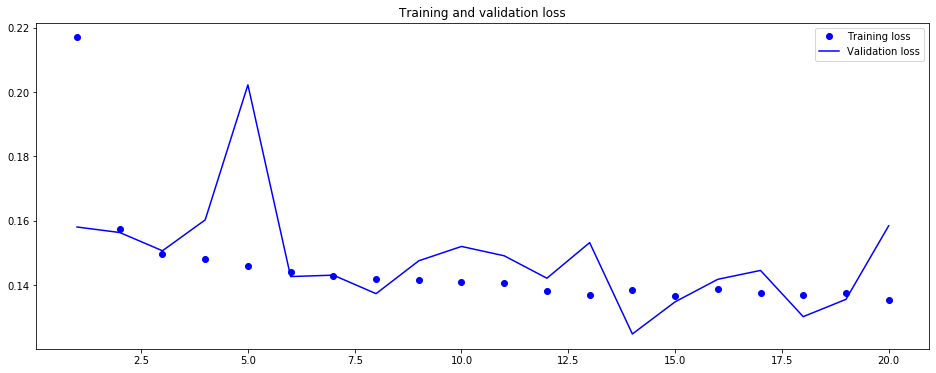

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### GRU를 사용한 모델을 훈련하고 평가하기

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1858 - val_loss: 0.1762
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1552 - val_loss: 0.1220
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1495 - val_loss: 0.1292
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1470 - val_loss: 0.1199
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1470 - val_loss: 0.1200
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1450 - val_loss: 0.1118
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1446 - val_loss: 0.1328
Epoch 8/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1426 - val_loss: 0.1231
Epoch 9/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1413 - val_loss: 0.1478
Epoch 

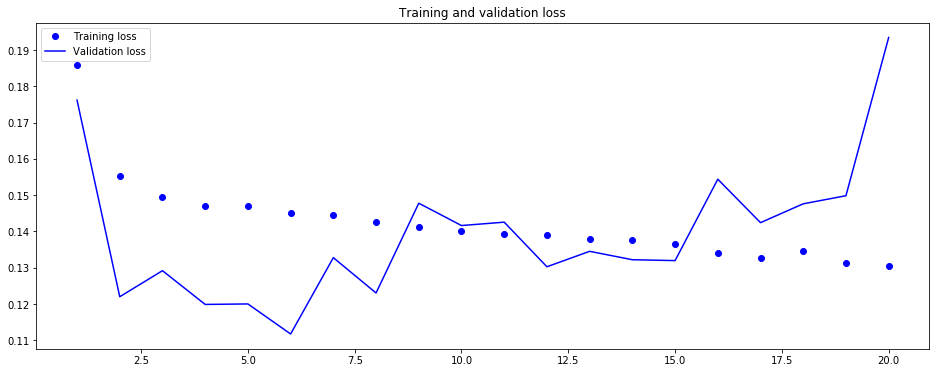

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3075 - val_loss: 0.1555
Epoch 2/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2812 - val_loss: 0.1511
Epoch 3/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2682 - val_loss: 0.1506
Epoch 4/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2559 - val_loss: 0.1454
Epoch 5/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2327 - val_loss: 0.1395
Epoch 6/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2159 - val_loss: 0.1442
Epoch 7/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2027 - val_loss: 0.1375
Epoch 8/40
500/500 [==============================] - 3s 7ms/step - loss: 0.1967 - val_loss: 0.1447
Epoch 9/40
500/500 [==============================] - 3s 7ms/step - loss: 0.1935 - va

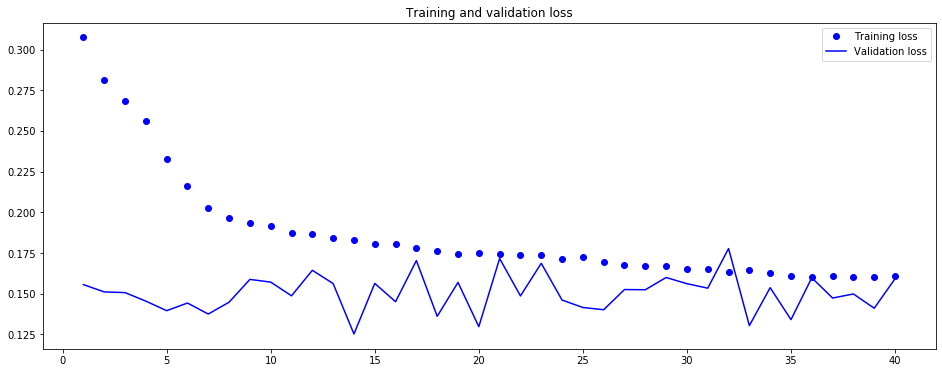

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3171 - val_loss: 0.1569
Epoch 2/40
500/500 [==============================] - 4s 7ms/step - loss: 0.2807 - val_loss: 0.1504
Epoch 3/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2739 - val_loss: 0.1658
Epoch 4/40
500/500 [==============================] - 4s 7ms/step - loss: 0.2597 - val_loss: 0.1675
Epoch 5/40
500/500 [==============================] - 3s 7ms/step - loss: 0.2427 - val_loss: 0.1634
Epoch 6/40
500/500 [==============================] - 4s 7ms/step - loss: 0.2283 - val_loss: 0.1553
Epoch 7/40
500/500 [==============================] - 4s 7ms/step - loss: 0.2138 - val_loss: 0.1760
Epoch 8/40
500/500 [==============================] - 4s 7ms/step - loss: 0.2067 - val_loss: 0.1473
Epoch 9/40
500/500 [==============================] - 4s 7ms/step - loss: 0.1991 - val_loss: 0.1462
Epoch 10/40
500/500 [==============================] - 3s 7ms/step - loss: 0.1921 - val_loss: 0.1607

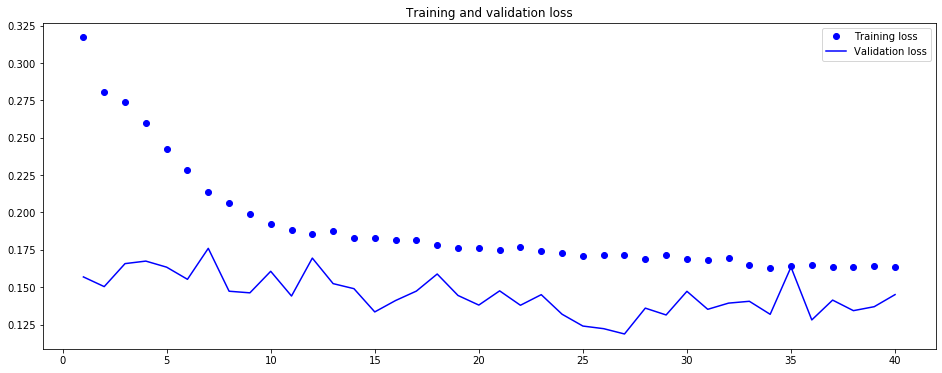

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기

In [27]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

train_gen_reverse = reverse_order_generator(
    data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

NameError: name 'float_data' is not defined

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16,6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test  결과

In [ ]:
len(model.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])

In [ ]:
import seaborn as sns
result = pd.DataFrame(model.predict_generator(test_gen, steps=test_steps+1)*std[-1] + mean[-1])
result.columns = ['pred']
plt.figure(figsize=(20,8))
sns.lineplot(data=result, palette="tab10", linewidth=2.5)
plt.show()

In [ ]:
import pandas as pd
data = pd.read_csv('../data/DAILY_DATA.csv')
data = data.set_index('date')
data = data.dropna(axis=1)
plt.figure(figsize=(20,8))
data['2019-02-01':'2020-01-31']['USD'].plot()
plt.show()